<a href="https://colab.research.google.com/github/MariaSun/Simple_cpp_nn/blob/main/mnist_gen1_5_Shurui.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe
from scipy import signal
from scipy import misc
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import Compose
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pylab import *
import tensorflow as tf

In [6]:
torch.cuda.is_available()

True

In [7]:
'''torch.cuda.set_device(0)
torch.set_default_tensor_type('torch.cuda.FloatTensor')'''

"torch.cuda.set_device(0)\ntorch.set_default_tensor_type('torch.cuda.FloatTensor')"

Import dataset (MNIST)

In [8]:
BATCH_SIZE = 64

transform = transforms.Compose(
    [transforms.ToTensor()])

train_transform = Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    #transforms.Normalize([0, 0, 0], [1, 1, 1])
])

test_transform = Compose([
    transforms.ToTensor(),
    #transforms.Normalize([0, 0, 0], [1, 1, 1])
])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,drop_last=True,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,drop_last=True,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')
'''
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transform, target_transform=None, download=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,drop_last=True,
                                          shuffle=True, pin_memory=False, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transform, target_transform=None, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,drop_last=True,
                                         shuffle=False, pin_memory=False, num_workers=8)
'''                                         


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



"\ntrainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transform, target_transform=None, download=True)\n\ntrainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,drop_last=True,\n                                          shuffle=True, pin_memory=False, num_workers=8)\n\ntestset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transform, target_transform=None, download=True)\ntestloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,drop_last=True,\n                                         shuffle=False, pin_memory=False, num_workers=8)\n"

Define the network structure

In [9]:
device = torch.device("cuda:0")
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Apr  6 20:44:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
def test():
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          # imshow(data[0][0][0])
          # plt.show(data[1][0])
          # print(data)
          # print('____________')
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %f %%' % (
      100 * correct / total))

In [11]:
pip install torchshow

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn import init
from torch.nn.modules import Module
from torch.nn.modules.utils import _single, _pair, _triple

import torchshow as ts

class _ConvNd(Module):

    __constants__ = ['stride', 'padding', 'dilation', 'groups', 'bias',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_size']   

    def __init__(self, in_channels, out_channels, kernel_size, batch_size, stride,
                 padding, dilation, transposed, output_padding,
                 groups, bias, padding_mode):
        super(_ConvNd, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.batch_size = batch_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        self.padding_mode = padding_mode
        if transposed:
            self.weight = Parameter(torch.Tensor(
                in_channels, out_channels // groups, *kernel_size))
        else:
            self.weight = Parameter(torch.Tensor(
                out_channels, in_channels // groups, *kernel_size))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        #init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        init.kaiming_normal_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        return s.format(**self.__dict__)

    def __setstate__(self, state):
        super(_ConvNd, self).__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'

class FTconvlayer(_ConvNd):
    def __init__(self, in_channels, out_channels, kernel_size, batch_size = 16, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros'):
        batch_size = BATCH_SIZE
        kernel_size = _pair(kernel_size) 
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(FTconvlayer, self).__init__(
            in_channels, out_channels, kernel_size, batch_size, stride, padding, dilation,
            False, _pair(0), groups, bias, padding_mode)

    def quantization_n(self, input, n = 1, max = 1):
      intv = max/(2**n-1)
      qunt = torch.ceil(torch.mul(input,(1/intv)))  #***use ceil instead of floor for small value of n to make sure that not all weights are modified to zero in the beginning, achieves good accuracy for small n
      #the above line divide the whole tensor by the smallest interval (1/2**n-1), which is same as multiply with 2**n-1, then take the floor and finally multiply the whole tensor with the smallest interval
      out = torch.mul(qunt,intv)
      out = torch.clamp(out, min=0, max=max) #make sure the quantized version lies in the interval 0-1, if it's bigger than one just clamp it at one
      return(out)  

    def make_complex(self, x):  #converts a real tensor into complex form by adding one extra dimension to it
        #x_i = torch.zeros(x.shape)
        x_i = torch.cuda.FloatTensor(x.shape).fill_(0)
        y = torch.stack((x,x_i),-1)
        return torch.view_as_complex(y)

    def neg_complex_exp(self, x):    #since pytorch does not support complex exponential, implemented using euler formula exp(-jx)=cos(-x)+jsin(-x)
        x_cos = torch.cos(-x)
        x_sin = torch.sin(-x)
        x_euler = torch.stack((x_cos, x_sin), -1)
        return torch.view_as_complex(x_euler)

    def complex_mul(self, x,y):  #this implementation should support broadcasting 
        result = x*y
        return result

    def conj_transpose(self, x):  #should support broadcasting
        x = torch.view_as_real(x)
        size = len(x.size())
        x_r = x[...,0]
        x_i = x[...,1]
        x_i_c =-x_i
        x_conj = torch.stack((x_r,x_i_c),-1)
        x_conj_t = torch.transpose(x_conj, size-3, size-2)#size-1 is the dimension for complex representation
        return torch.view_as_complex(x_conj_t)

    def roll_n(self, X, axis, n):
        f_idx = tuple(slice(None, None, None) if i != axis else slice(0, n, None) for i in range(X.dim()))
        b_idx = tuple(slice(None, None, None) if i != axis else slice(n, None, None) for i in range(X.dim()))
        front = X[f_idx]
        back = X[b_idx]
        return torch.cat([back, front], axis)   


    def propTF(self, u1,L,lambdaa,z):
        batch,M,N = u1.shape
        dx = L/M
        fx = torch.arange(-1/(2*dx),1/(2*dx), 1/L).cuda()
        FX,FY = torch.meshgrid(fx,fx)
        #H = torch.exp(-1j*math.pi*lambdaa*z*(FX**2+FY**2))
        H = self.neg_complex_exp(math.pi*lambdaa*z*(FX**2+FY**2))
        #H = self.batch_fftshift2d(H)
        H = torch.fft.fftshift(H)
        U1 = torch.fft.fft2(torch.fft.fftshift(u1)) #so the U1's dimension is 4, H is 3 so complex_mul needs to support broadcasting
        U2 = self.complex_mul(H,U1)
        u2 = torch.fft.ifftshift(torch.fft.ifft2(U2)) #this step is redundent, can be removed in actual implementation
        return u2


    def seidel_5(self, u0, v0, X, Y, wd, w040, w131, w222, w220, w311):
        beta = math.atan2(u0,v0)
        u0r=math.sqrt(u0**2+v0**2)
        Xr=X*math.cos(beta)+Y*math.sin(beta)
        Yr=-X*math.sin(beta)+Y*math.cos(beta)
        rho2=Xr**2+Yr**2
        w=wd*rho2+w040*rho2**2+w131*u0r*rho2*Xr+ w222*u0r**2*Xr**2+w220*u0r**2*rho2+w311*math.pow(u0r,3)*Xr
        return w

    def circ(self, r):
        out = torch.abs(r)<=1
        return out
    
    def input_pad(self,input,padsize):
      input_size = input.shape[2]
      pad_size_x = int((padsize-input_size)/2)
      pad_size_y = int((padsize-input_size)/2)
      p2d = (pad_size_x, pad_size_y, pad_size_x, pad_size_y)
      input_pad = F.pad(input, p2d, "constant", 0)
      return input_pad 


    def kernel_hpf_even(self, input, amount):
      # make the center part of the weight to be zero and make the filter symmetrical
      # This function should be placed before quantization
      # amount is the size of the area that are set to 0
      mid = int(input.shape[2]/2)
      input[:,mid-amount:mid+amount,mid-amount:mid+amount] = 0 #set the center part to be zero

      input_transpose = torch.transpose(input, 1,2)
      input = (input + input_transpose)/2
      #even = input
      return input

    def accurate_model_forward(self, input, weight):
        err = 1e-8 #define a very small error term to aviod nan loss due to abs
        res = input.shape[2]
        xx = res
        yy = xx 
        w = res    
        n_filter_actual = int(self.out_channels/2)
        output_full = torch.cuda.FloatTensor(BATCH_SIZE,self.out_channels,w,w).fill_(0)
        output_sub = torch.cuda.FloatTensor(BATCH_SIZE, int(self.out_channels/2), w, w).fill_(0)
        # Define unit matrix DMD 
        '''unitmatrix = torch.cuda.FloatTensor(17, 17).fill_(0)
        unitmatrix[1:16,1:16]=1
        unitmatrix[7:10,7:10]=0
        idledmd = unitmatrix.repeat(xx,yy)
        '''
        idledmd = torch.cuda.FloatTensor(res, res).fill_(1)
        M,N = idledmd.shape
        L1=1.90e-2*xx/res
        L2=1.09e-2*yy/res
        du=L1/M
        dv=L2/N
        lambdaa = 0.633e-6
        k=2*math.pi/lambdaa
        
        '''Lens Diffraction (Aperture) and Aberration'''
        fu = torch.arange(-1/(2*du),1/(2*du),1/L1)
        fv = torch.arange(-1/(2*dv),1/(2*dv),1/L2)
        Dxp = 5e-2
        wxp = Dxp/2
        zxp = 200e-3
        lz = lambdaa*zxp
        u0 = 0
        v0 = 0
        f0 = wxp/(lambdaa*zxp)
        '''Lens parameter for aberration (Seidel coefficients), wavefront alteration from spherical waves'''
        wd=0*lambdaa
        w040=4.963*lambdaa
        w131=2.637*lambdaa
        w222=9.025*lambdaa
        w220=7.536*2*lambdaa
        w311=0.157*12*lambdaa
        
        Fu,Fv = torch.meshgrid(fu,fv)
        Fu = torch.transpose(Fu,0,1)
        Fv = torch.transpose(Fv,0,1)
        W = self.seidel_5(u0,v0,-lz*Fu/wxp,-lz*Fv/wxp,wd,w040,w131,w222,w220,w311).cuda() #same as the matlab calculation
        H = self.complex_mul(self.make_complex(self.circ(torch.sqrt(Fu**2 + Fv**2)/f0).float().cuda()),self.neg_complex_exp(k*W))# lens? 
#-----------------------from here is the actual training, before the loop is basically constants/parameters genreation, which does not needs to be backproped     
        for c_in in range(input.shape[1]): # iters for number of input channels
            signal = input[:,c_in,:,:] #the dimension of signal is 3, with one batch dimension

            # ts.show(signal[0])

            weight_raw = weight[:,c_in,:,:] #the dimension of weights are now 3
            weight_raw.data = self.kernel_hpf_even(weight_raw.data,3)
            weight_raw.data = self.quantization_n(weight_raw.data, 1, 1)
            '''interleave dimension needs to be changed since now the first dimension is batch dimension'''
            dmd_1 = self.make_complex(self.input_pad(signal,res)) #dimension of dmd1 is now 4, first dimension is now batch dimension, so propTF needs to be changed accordingly

            # print(dmd_1[0].size())
            # print(type(dmd_1[0]))
            # ts.show(self.input_pad(signal,res)[0])

            #now need to implement propTF function
            # u2 = self.propTF(dmd_1,1.9e-2, lambdaa, 1.9e-2)
            
            '''Fourier Transform after first lens'''
            Gg = torch.fft.fftshift(torch.fft.fft2(dmd_1))
            # Gi = self.complex_mul(Gg,self.conj_transpose(H))
            Gi = Gg.unsqueeze(1)
            
            '''dot product in the fourier plane'''
            Gii = self.complex_mul(Gi,self.make_complex(weight_raw))
            '''Then get the result in real space'''
            Grs = torch.fft.ifft2(torch.fft.ifftshift(Gii))
            Grs = torch.view_as_real(Grs)#.   field output
            #Ii = torch.abs(Grs)**2
            Ii = torch.sqrt(Grs[...,0]**2+Grs[...,1]**2+err)#   camera output (take the squre to represent light intensity)
            op_abs = Ii
            output_full += op_abs
        return output_full

    def forward(self, input):
        return self.accurate_model_forward(input, self.weight)
        


class FFTconv(nn.Module):
    def __init__(self):
        super(FFTconv, self).__init__()
        self.conv1 = FTconvlayer(1, 16, 28) #outdimension should be [32,16,28,28] (1/3,:,5/28/32) depends on whether training in fourier domain or no
        #self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc01 = nn.Linear(16 * 14 * 14, 256)
        self.fc02 = nn.Linear(256, 10)
        self.drop_layer = nn.Dropout(p=0.3)
    
    def forward(self, x):
        #x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.bn1(self.pool1(self.conv1(x)))
        x = x.view(-1, 16 * 14 * 14)
        #x = self.drop_layer(x)
        x = F.relu(self.fc01(x))
        #x = self.drop_layer(x)
        x = self.fc02(x)
        return x

net = FFTconv()    


if device:
    net.to(device)
    #torch.backends.cudnn.benchmark = True
    print("put net onto GPU")
print(net)



put net onto GPU
FFTconv(
  (conv1): FTconvlayer(1, 16, kernel_size=(28, 28), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc01): Linear(in_features=3136, out_features=256, bias=True)
  (fc02): Linear(in_features=256, out_features=10, bias=True)
  (drop_layer): Dropout(p=0.3, inplace=False)
)


In [15]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001) #default learning rate for adam is 0.001
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def adjust_learning_rate(optimizer, epoch, init_lr, freq):
    """Sets the learning rate to the initial LR decayed by 2 every n epochs"""
    lr = init_lr * (0.3 ** (epoch // freq))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [17]:
for epoch in range(25):  # loop over the dataset multiple times
    print('Training epoch ...')
    start_time = time.time()
    running_loss = 0.0
    adjust_learning_rate(optimizer, epoch, 0.001, 10)
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    test()

print('Finished Training')


Training epoch ...
[1,   200] loss: 0.006
[1,   400] loss: 0.072
[1,   600] loss: 0.021
[1,   800] loss: 0.012
Accuracy of the network on the 10000 test images: 98.587740 %
Training epoch ...
[2,   200] loss: 0.006
[2,   400] loss: 0.007
[2,   600] loss: 0.011
[2,   800] loss: 0.016
Accuracy of the network on the 10000 test images: 98.657853 %
Training epoch ...
[3,   200] loss: 0.008
[3,   400] loss: 0.006
[3,   600] loss: 0.010
[3,   800] loss: 0.006
Accuracy of the network on the 10000 test images: 98.687901 %
Training epoch ...
[4,   200] loss: 0.005
[4,   400] loss: 0.002
[4,   600] loss: 0.008
[4,   800] loss: 0.007
Accuracy of the network on the 10000 test images: 98.407452 %
Training epoch ...
[5,   200] loss: 0.012
[5,   400] loss: 0.009
[5,   600] loss: 0.008
[5,   800] loss: 0.004
Accuracy of the network on the 10000 test images: 98.747997 %
Training epoch ...
[6,   200] loss: 0.003
[6,   400] loss: 0.002
[6,   600] loss: 0.008
[6,   800] loss: 0.008
Accuracy of the network 

In [18]:
test()

Accuracy of the network on the 10000 test images: 99.058494 %


In [11]:
#functions required to generate final weights
def quantization_n(input, n = 1, max = 1):
  intv = max/(2**n-1)
  qunt = torch.ceil(torch.mul(input,(1/intv)))  #***use ceil instead of floor for small value of n to make sure that not all weights are modified to zero in the beginning, achieves good accuracy for small n
  #the above line divide the whole tensor by the smallest interval (1/2**n-1), which is same as multiply with 2**n-1, then take the floor and finally multiply the whole tensor with the smallest interval
  out = torch.mul(qunt,intv)
  out = torch.clamp(out, min=0, max=max) #make sure the quantized version lies in the interval 0-1, if it's bigger than one just clamp it at one
  return(out) 

# def kernel_even(input):
#   dim = len(input.shape)
#   print(dim)
#   input_transpose = torch.transpose(input,dim-2,dim-1)
#   input = (input + input_transpose)/2
#   return input

def kernel_hpf_even(input, amount):
  # make the center part of the weight to be zero and make the filter symmetrical
  # This function should be placed before quantization
  # amount is the size of the area that are set to 0
  mid = int(input.shape[2]/2)
  dim = len(input.shape)
  input[...,mid-amount:mid+amount,mid-amount:mid+amount] = 0 #set the center part to be zero
  print(dim)
  input_transpose = torch.transpose(input, dim-2,dim-1)
  input = (input + input_transpose)/2
  #even = input
  return input

In [12]:
weights = torch.clone(net.state_dict()['conv1.weight'])
weights = kernel_hpf_even(weights,3)
#weights = kernel_even(weights)
weights = quantization_n(weights,1,1)
weights_np = weights.cpu().numpy()
np.save('mnist_even_hpf6',weights_np)
print(weights[7,0,10:18,10:18])#number of filters (16); number of input channels (1); x,y
#print(net.state_dict()['conv1.weight'][10,...]) 

4
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 1., 0., 0.]], device='cuda:0')


In [13]:
from pylab import *

In [14]:
import tensorflow as tf

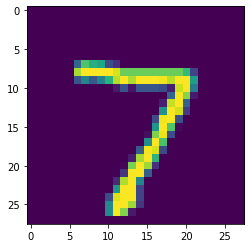

7


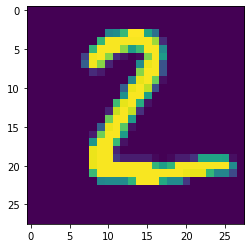

2


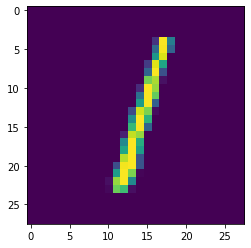

1


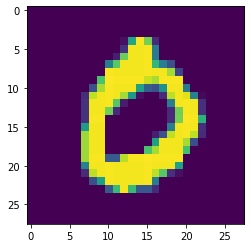

0


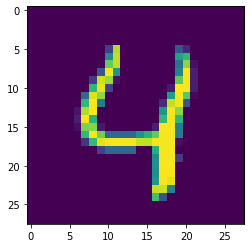

4


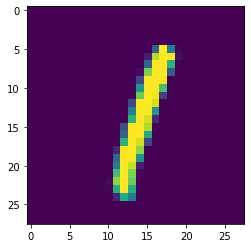

1


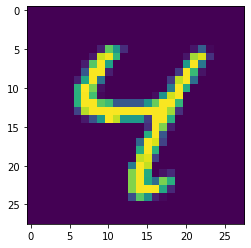

4


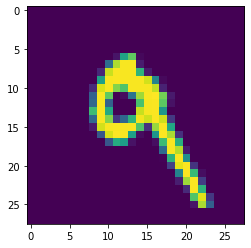

9


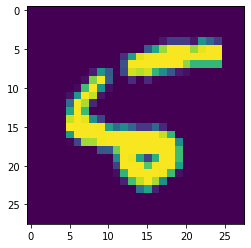

5


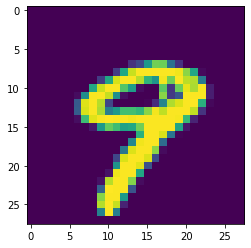

9


In [15]:
for i in range(10):
  test_image, test_target = testset[i]
  imshow(tf.squeeze(test_image))
  plt.show()
  print(test_target)